# CNN
This notebook aims to deploy the CNN.

## Setup for UCloud
The Setup on Ucloud is a bit feasty at times, so here are some workarounds

In [2]:
#pip freeze > requirements.txt

In [ ]:
!pip install -r requirements.txt
!pip install matplotlib opencv-python pandas scikit-learn tensorflow
!pip install numpy==1.26.4 --force-reinstall
!pip install editdistance
!pip install tqdm


# scipy
!pip install --upgrade --force-reinstall --no-cache-dir scipy
!pip install --upgrade --force-reinstall --no-cache-dir scikit-learn


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.3/604.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 60.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 70.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 90.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!sudo apt-get update
!sudo apt-get install -y libgl1
# !sudo apt-get -y upgrade
# git clone git@github.com:LinusLinuxer/SPECIALIZATION-PROEJECT.git


Get:1 http://security.ubuntu.com/ubuntu noble-security InRelease [126 kB]
Get:2 http://archive.ubuntu.com/ubuntu noble InRelease [256 kB]                
Get:3 http://security.ubuntu.com/ubuntu noble-security/universe amd64 Packages [1088 kB]
Get:4 http://archive.ubuntu.com/ubuntu noble-updates InRelease [126 kB]
Get:5 http://security.ubuntu.com/ubuntu noble-security/multiverse amd64 Packages [22.1 kB]
Get:6 http://security.ubuntu.com/ubuntu noble-security/main amd64 Packages [1081 kB]
Get:7 http://security.ubuntu.com/ubuntu noble-security/restricted amd64 Packages [1434 kB]
Get:8 http://archive.ubuntu.com/ubuntu noble-backports InRelease [126 kB]      
Get:9 http://archive.ubuntu.com/ubuntu noble/restricted amd64 Packages [117 kB]
Get:10 http://archive.ubuntu.com/ubuntu noble/main amd64 Packages [1808 kB]
Get:11 http://archive.ubuntu.com/ubuntu noble/multiverse amd64 Packages [331 kB]
Get:12 http://archive.ubuntu.com/ubuntu noble/universe amd64 Packages [19.3 MB]
Get:13 http://archive

In [3]:
# Set your name
!git config --global user.name "Linus Engelbrecht"

# Set your email
!git config --global user.email "linusengelbrecht@web.de"

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from editdistance import eval as edit_distance
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import ctc_decode
from tensorflow.keras.optimizers import Adam


---
## Loading the data
Data has to load out of the 'carolianminuscule-groundtruth'-folder 

In [ ]:
def get_images(folder_path: str):
    """
    Load images and text files from the given path.
    :param folder_path: Path to the directory containing images and text files.
    :return: Two lists - one for image paths and one for text file paths.
    """
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Path {folder_path} does not exist.")

    images = []
    files = []

    for entry in os.listdir(folder_path):
        entry_path = os.path.join(folder_path, entry)
        if os.path.isdir(entry_path):
            # Recursively get images and text files from subdirectories
            sub_images, sub_files = get_images(entry_path)
            images.extend(sub_images)
            files.extend(sub_files)
        elif entry.endswith(".png"):
            images.append(entry_path)
        elif entry.endswith(".txt"):
            files.append(entry_path)

    return images, files


# load the data from the directory
path = "dataset"
images, files = get_images(path)


# matched the .png- and .txt-file in a folder together
# This might take a while, but it works
matched_list_path = [
    [img, file]
    for img in images
    for file in files
    if os.path.dirname(img) == os.path.dirname(file)
    and os.path.splitext(os.path.splitext(os.path.basename(img))[0])[0]
    == os.path.splitext(os.path.splitext(os.path.basename(file))[0])[0]
]


In [7]:
print(f"len matched: {len(matched_list_path)}")
print(f"matched_list:\n {matched_list_path[1]}")

len matched: 7109
matched_list:
 ['dataset/20250527_151943_617254_1880.png', 'dataset/20250527_151943_617254_1880.txt']


---
## Creating the Dataset

In [16]:
# define a dataframe to store the image, image paths and their corresponding text files
df = pd.DataFrame(columns=["name", "image", "transcription"])

# Loop with progress bar
for i, (img_path, file_path) in tqdm(enumerate(matched_list_path), total=len(matched_list_path), desc="Processing"):
    # Load the image
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply binary threshold
    _, bw = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Assign processed image
    img = bw

    # Add the image and filename to DataFrame
    df.loc[i] = [os.path.basename(img_path), img, None]

    # Read transcription from file
    with open(file_path, "r", encoding="utf-8") as f:
        transcription = f.read()

    # Assign transcription
    df.loc[i, "transcription"] = transcription

Processing: 100%|██████████| 7109/7109 [00:46<00:00, 153.69it/s]


In [12]:
# delete all the linebrakes in the transcription
df["transcription"] = df["transcription"].str.replace("\n", "", regex=False)
df.head(5)

,name,image,transcription
0,20250527_151910_143841_170.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",ieces. And as if to show that all things were now
1,20250527_151943_617254_1880.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",He has no idea what to make of the situation. He
2,20250527_151945_994834_2019.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","We get up. ""Where's Tjaden?"" the sergeant puffs."
3,20250527_151950_066418_2237.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",e can a man do?--The coffins are really for us...
4,20250527_151938_440241_1585.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",". Someone plumps down behind me, another. I wi..."


---
## Preparing the data

By calculating the maximum and avg. number of the height we can use that value later in our CNN.

In [17]:
# Features (images) and labels (transcriptions)
X = df["image"].values          # Images as NumPy arrays
y = df["transcription"].values  # Transcriptions as strings

In [18]:
#strech images to 3000
X = np.array(
    [cv2.resize(img, (3000, 256)) for img in df["image"]], dtype=np.float32
)


print(f"X shape: {X.shape}, dtype: {X.dtype}")

X shape: (7109, 256, 3000), dtype: float32


In [19]:
# 1) Build the base charset from your transcriptions
charset = sorted(set("".join(df["transcription"])))

# 2) Append the CTC blank token (we’ll represent it as the empty string '')
blank_char = ""
charset.append(blank_char)

# 3) Now build your mappings
char_to_index = {char: idx for idx, char in enumerate(charset)}
index_to_char = {idx: char for char, idx in char_to_index.items()}

# 4) Number of classes is now exactly the size of charset
num_classes = len(charset)

# 5) Remap your labels (they only contain real chars, so they’ll be in [0..num_classes-2])
label_sequences = [
    [char_to_index[char] for char in transcription]
    for transcription in df["transcription"]
]

# 6) Pad with the blank index (which is now the last index = num_classes-1)
max_sequence_length = 256
padded_labels = pad_sequences(
    label_sequences,
    maxlen=max_sequence_length,
    padding="post",
    value=char_to_index[blank_char],  # = num_classes - 1
)

print(f"Character set (+ blank): {charset!r}")
print(f"Number of classes: {num_classes}")
print(f"Blank index: {char_to_index[blank_char]}")
print(f"y shape: {y.shape}, dtype: {y.dtype}")
print(f"char to index {char_to_index}")

Character set (+ blank): [' ', '!', '"', '#', '$', '%', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '°', 'ä', 'æ', 'ç', 'ê', 'ô', 'ö', 'ü', '—', '‘', '’', '“', '”', '•', '™', '\ufeff', '']
Number of classes: 99
Blank index: 98
y shape: (7109,), dtype: object
char to index {' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, "'": 6, '(': 7, ')': 8, '*': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, ';': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 35, 'J': 36, 'K': 37, 'L': 38, 'M': 39, 'N': 40, 'O': 41, 'P': 42, 'Q': 43, 'R':

In [20]:
# Convert transcriptions to sequences of integers
label_sequences = [
    [char_to_index[char] for char in transcription]
    for transcription in df["transcription"]
]

# Pad sequences to a fixed length (use a value outside the valid character indices, like num_classes - 1 for blank)
padded_labels = pad_sequences(
    label_sequences, maxlen=max_sequence_length, padding="post", value=num_classes - 1
)


# Convert to NumPy array, not one-hot encoded because CTC loss expects integer sequences
y = np.array(padded_labels, dtype=np.int32)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [22]:
np.save("X_val.npy", X_test)
np.save("y_val.npy", y_test)  # Optional for CER/WER later


In [23]:
print(f"X_train shape: {X_train.shape}, dtype: {X_train.dtype}")
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")

X_train shape: (5687, 256, 3000), dtype: float32
y_train shape: (5687, 256), dtype: int32


---
## Data visualisation
Below I want to gain a better understanding of our datapoints

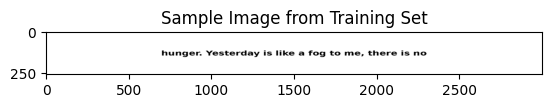

In [24]:
show_img_nr = 1

plt.imshow(X_train[show_img_nr], cmap="gray", vmin=0, vmax=255)
plt.title("Sample Image from Training Set")
plt.show()

In [25]:
print("First entry in y_train:")
print(y_train[show_img_nr])

First entry in y_train:
[63 76 69 62 60 73 12  0 51 60 74 75 60 73 59 56 80  0 64 74  0 67 64 66
 60  0 56  0 61 70 62  0 75 70  0 68 60 10  0 75 63 60 73 60  0 64 74  0
 69 70 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98
 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98
 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98
 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98
 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98
 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98
 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98
 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98
 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98]


In [26]:
# Translate the first entry in y_train back to text using index_to_char
decoded_text = "".join(
    [index_to_char[idx] for idx in y_train[show_img_nr] if idx < len(index_to_char)]
)
print(decoded_text)

hunger. Yesterday is like a fog to me, there is no


---

## Evaluation metric

In [27]:
# DataFrame to store evaluation metrics
eval_metrics = pd.DataFrame(columns=["epoch", "ctc_loss", "val_loss", "cer", "wer"])

class MetricsLogger(keras.callbacks.Callback):
    def __init__(self, X_val, y_val, index_to_char):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.index_to_char = index_to_char

        # include blank in your class count
        self.num_classes = max(index_to_char.keys()) + 1

        # convention: blank is the last index
        self.blank_idx = self.num_classes - 1

    def on_epoch_end(self, epoch, logs=None):
        # 1) Predict on validation set
        y_pred = self.model.predict(self.X_val)
        batch_size, time_steps = y_pred.shape[0], y_pred.shape[1]

        # 2) Build integer input_length vector for CTC
        input_lengths = np.ones(batch_size, dtype=np.int32) * time_steps

        # 3) Decode with greedy CTC using tf.nn.ctc_greedy_decoder
        # Transpose to shape (time_steps, batch_size, num_classes)
        logits = tf.transpose(y_pred, [1, 0, 2])
        # sequence_length expects shape (batch_size,)
        seq_len = tf.ones((batch_size,), dtype=tf.int32) * time_steps
        decoded_sparse, _ = tf.nn.ctc_greedy_decoder(logits, seq_len)

        # 4) Convert SparseTensor -> dense numpy (pad with -1)
        decoded_dense = tf.sparse.to_dense(decoded_sparse[0], default_value=-1).numpy()

        # 5) Map indices to text strings, filtering blank and padding
        y_pred_texts = []
        for seq in decoded_dense:
            chars = [
                self.index_to_char[idx]
                for idx in seq
                if idx >= 0 and idx != self.blank_idx
            ]
            y_pred_texts.append("".join(chars))

        # 6) Build true texts from y_val (ignore blank index)
        y_true_texts = []
        for seq in self.y_val:
            chars = [
                self.index_to_char[idx]
                for idx in seq
                if idx != self.blank_idx and idx in self.index_to_char
            ]
            y_true_texts.append("".join(chars))

        # 7) Compute error rates
        cer = self.character_error_rate(y_true_texts, y_pred_texts)
        wer = self.word_error_rate(y_true_texts, y_pred_texts)

        # 8) Log to DataFrame and CSV
        self.log_metrics(epoch, logs, cer, wer)
        eval_metrics.to_csv("eval_metrics.csv", index=False)

        # Optional: print sample predictions
        print(f"\nEpoch {epoch+1} sample predictions:")
        for i, (t, p) in enumerate(zip(y_true_texts[:3], y_pred_texts[:3])):
            print(f"  true: {t} | pred: {p or '<empty>'}")

    def log_metrics(self, epoch, logs, cer, wer):
        eval_metrics.loc[epoch] = [
            epoch,
            logs.get("ctc_loss", logs.get("loss")),
            logs.get("val_loss"),
            cer,
            wer,
        ]

    @staticmethod
    def character_error_rate(y_true, y_pred):
        total_edits, total_chars = 0, 0
        for t, p in zip(y_true, y_pred):
            total_edits += edit_distance(t, p)
            total_chars += len(t)
        return total_edits / total_chars if total_chars > 0 else 0.0

    @staticmethod
    def word_error_rate(y_true, y_pred):
        total_edits, total_words = 0, 0
        for t, p in zip(y_true, y_pred):
            total_edits += edit_distance(t.split(), p.split())
            total_words += len(t.split())
        return total_edits / total_words if total_words > 0 else 0.0


def ctc_loss(y_true, y_pred):
    input_length = tf.ones(shape=(tf.shape(y_pred)[0], 1), dtype=tf.int32) * tf.shape(y_pred)[1]
    label_length = tf.ones(shape=(tf.shape(y_true)[0], 1), dtype=tf.int32) * tf.shape(y_true)[1]
    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)


---
## Training


In [28]:
cnn_rnn = keras.Sequential(
    [
        # CNN layers
        layers.Conv2D(
            64, (3, 3), padding="same", activation="relu", input_shape=(256, 3000, 1)
        ),  # → (256, 3000, 64)
        layers.MaxPooling2D(pool_size=(2, 2)),  # → (128, 1500, 64)
        layers.Conv2D(
            128, (3, 3), padding="same", activation="relu"
        ),  # → (128, 1500, 128)
        layers.MaxPooling2D(pool_size=(2, 2)),  # → (64, 750, 128)
        # reshape for RNN
        layers.Reshape(target_shape=(750, 64 * 128)),  # → (750, 8192)
        # RNN layers
        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        # Output layer
        layers.Dense(num_classes, activation="softmax"),
    ]
)

cnn_rnn.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=5), loss=ctc_loss)

metrics_logger = MetricsLogger(X_test, y_test, index_to_char)

/home/ucloud/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-27 15:50:49.536215: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [29]:
print(X_train.shape)  # (batch, 256, 4096, 1)
print(y_train.shape)


(5687, 256, 3000)
(5687, 256)


In [32]:
# fit the model
history = cnn_rnn.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    batch_size=16,
    callbacks=[metrics_logger]
)

Epoch 1/20


2025-05-27 15:51:53.371975: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17470464000 exceeds 10% of free system memory.


ValueError: Attr 'Toutput_types' of 'OptionalFromValue' Op passed list of length 0 less than minimum 1.

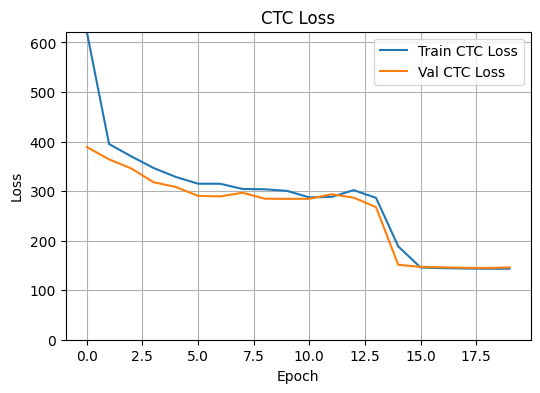

In [ ]:
# 3) Plot train vs. val CTC loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],   label='Train CTC Loss')
plt.plot(history.history['val_loss'], label='Val CTC Loss')
plt.title(f'CTC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
sample = X_test[0:1]
pred = cnn_rnn.predict(sample)
decoded, _ = ctc_decode(pred, input_length=[pred.shape[1]], greedy=True)
print("Predicted:", decoded[0].numpy())
print("Argmax sequence:", np.argmax(pred[0], axis=-1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicted: [[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 

In [ ]:
print("Model output shape:", cnn_rnn.output_shape)

Model output shape: (None, 750, 84)


In [ ]:
print("Softmax mean/max values:", np.mean(pred[0], axis=1), np.max(pred[0], axis=1))

Softmax mean/max values: [0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.0

In [ ]:
eval_metrics

,epoch,ctc_loss,val_loss,cer,wer
0,0.0,621.641235,388.920227,0.979353,1.000000
1,1.0,395.006378,364.033875,0.979353,1.000000
2,2.0,370.052643,345.756561,0.979353,1.000000
3,3.0,346.702576,317.886017,0.979353,1.000000
4,4.0,328.510590,308.290222,0.979353,1.000000
5,5.0,314.938171,290.340698,0.958706,1.000000
6,6.0,314.779694,289.339996,0.979353,1.000000
7,7.0,304.242554,296.603180,0.931095,1.003044
8,8.0,303.631287,284.629211,0.932090,1.003044
9,9.0,300.396698,284.338165,0.979353,1.000000


In [31]:
cnn_rnn.save("modern_model-CNN_RNN_model.keras")